<h2>Credit Card Holder Defaulter Classification</h2>

In [57]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

### 1. Understanding the problem</a>
<hr>

In [4]:
df_carddata = pd.read_csv("data/UCI_Credit_Card.csv")
df_carddata.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [6]:
df_carddata.shape

(30000, 25)

The goal of this project is to predict whether the credit card client will default or not. The column that determines this is <b>default.payment.next.month</b>. It is the <b>target variable</b> with value either 1(will default) or 0(not default). This tells us that it is a <b>binary classification problem</b>.

The dataset is of a <b>moderate size with 30,000 examples</b> and <b>25 features which is a small dimension</b>.

### 2. Data Splitting</a>
<hr>

In [8]:
train_data, test_data = train_test_split(df_carddata, test_size=0.2, random_state=123)

In [9]:
train_data.shape

(24000, 25)

In [10]:
test_data.shape

(6000, 25)

### 3. EDA</a>
<hr>

In [13]:
X_train, y_train = train_data.drop(columns=["ID","default.payment.next.month"]), train_data["default.payment.next.month"]
X_test, y_test = test_data.drop(columns=["ID","default.payment.next.month"]), test_data["default.payment.next.month"]

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 19682 to 19966
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  24000 non-null  float64
 1   SEX        24000 non-null  int64  
 2   EDUCATION  24000 non-null  int64  
 3   MARRIAGE   24000 non-null  int64  
 4   AGE        24000 non-null  int64  
 5   PAY_0      24000 non-null  int64  
 6   PAY_2      24000 non-null  int64  
 7   PAY_3      24000 non-null  int64  
 8   PAY_4      24000 non-null  int64  
 9   PAY_5      24000 non-null  int64  
 10  PAY_6      24000 non-null  int64  
 11  BILL_AMT1  24000 non-null  float64
 12  BILL_AMT2  24000 non-null  float64
 13  BILL_AMT3  24000 non-null  float64
 14  BILL_AMT4  24000 non-null  float64
 15  BILL_AMT5  24000 non-null  float64
 16  BILL_AMT6  24000 non-null  float64
 17  PAY_AMT1   24000 non-null  float64
 18  PAY_AMT2   24000 non-null  float64
 19  PAY_AMT3   24000 non-null  float64
 20  PA

There are <b>no missing values</b> and all the columns are <b>encoded as numerical columns</b>. SEX, EDUCATION, MARRIAGE are more likely to be categorical features. 

In [18]:
y_train.value_counts(normalize=True)

0    0.777833
1    0.222167
Name: default.payment.next.month, dtype: float64

The class distribution of the target value is 77.8% and 22.2%. This statistics show that the classes are <b>imbalanced</b>. Both the classes seems important here. Precision is an important metric here since false positive will lead to customer dissatisfaction. Also, recall is an important metric since false negative will lead to credit card companies not knowing the actual defaulters correctly leading to financial loss to the company. So, we need a metric which balances both precision and recall. Therefore, we should choose <b>macro-average f1 score</b> as the evaluation metrics. 

In [25]:
X_train.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000
mean,167893.486667,1.603125,1.851958,1.553375,35.488458,-0.017542,-0.135292,-0.170042,-0.224292,-0.265583,...,46955.185083,43389.105625,40297.970375,38708.777542,5656.319917,5.910454e+03,5280.658708,4763.854250,4805.837667,5277.577958
std,130109.666875,0.489260,0.790560,0.521452,9.217424,1.125331,1.199812,1.201709,1.170630,1.136707,...,68841.868958,64572.844994,60878.153831,59355.284889,16757.718059,2.134743e+04,17973.951980,15162.056345,15251.828322,18222.046645
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-157264.000000,-65167.000000,-61372.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2663.000000,2310.000000,1744.250000,1200.000000,990.000000,8.150000e+02,390.000000,281.750000,234.000000,110.750000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,20038.000000,19032.000000,18019.000000,16812.500000,2100.000000,2.010000e+03,1801.500000,1500.000000,1500.000000,1500.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,59970.250000,54591.500000,50237.250000,49132.750000,5009.000000,5.000000e+03,4600.000000,4026.000000,4009.250000,4000.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,855086.000000,891586.000000,927171.000000,961664.000000,873552.000000,1.227082e+06,896040.000000,621000.000000,426529.000000,528666.000000


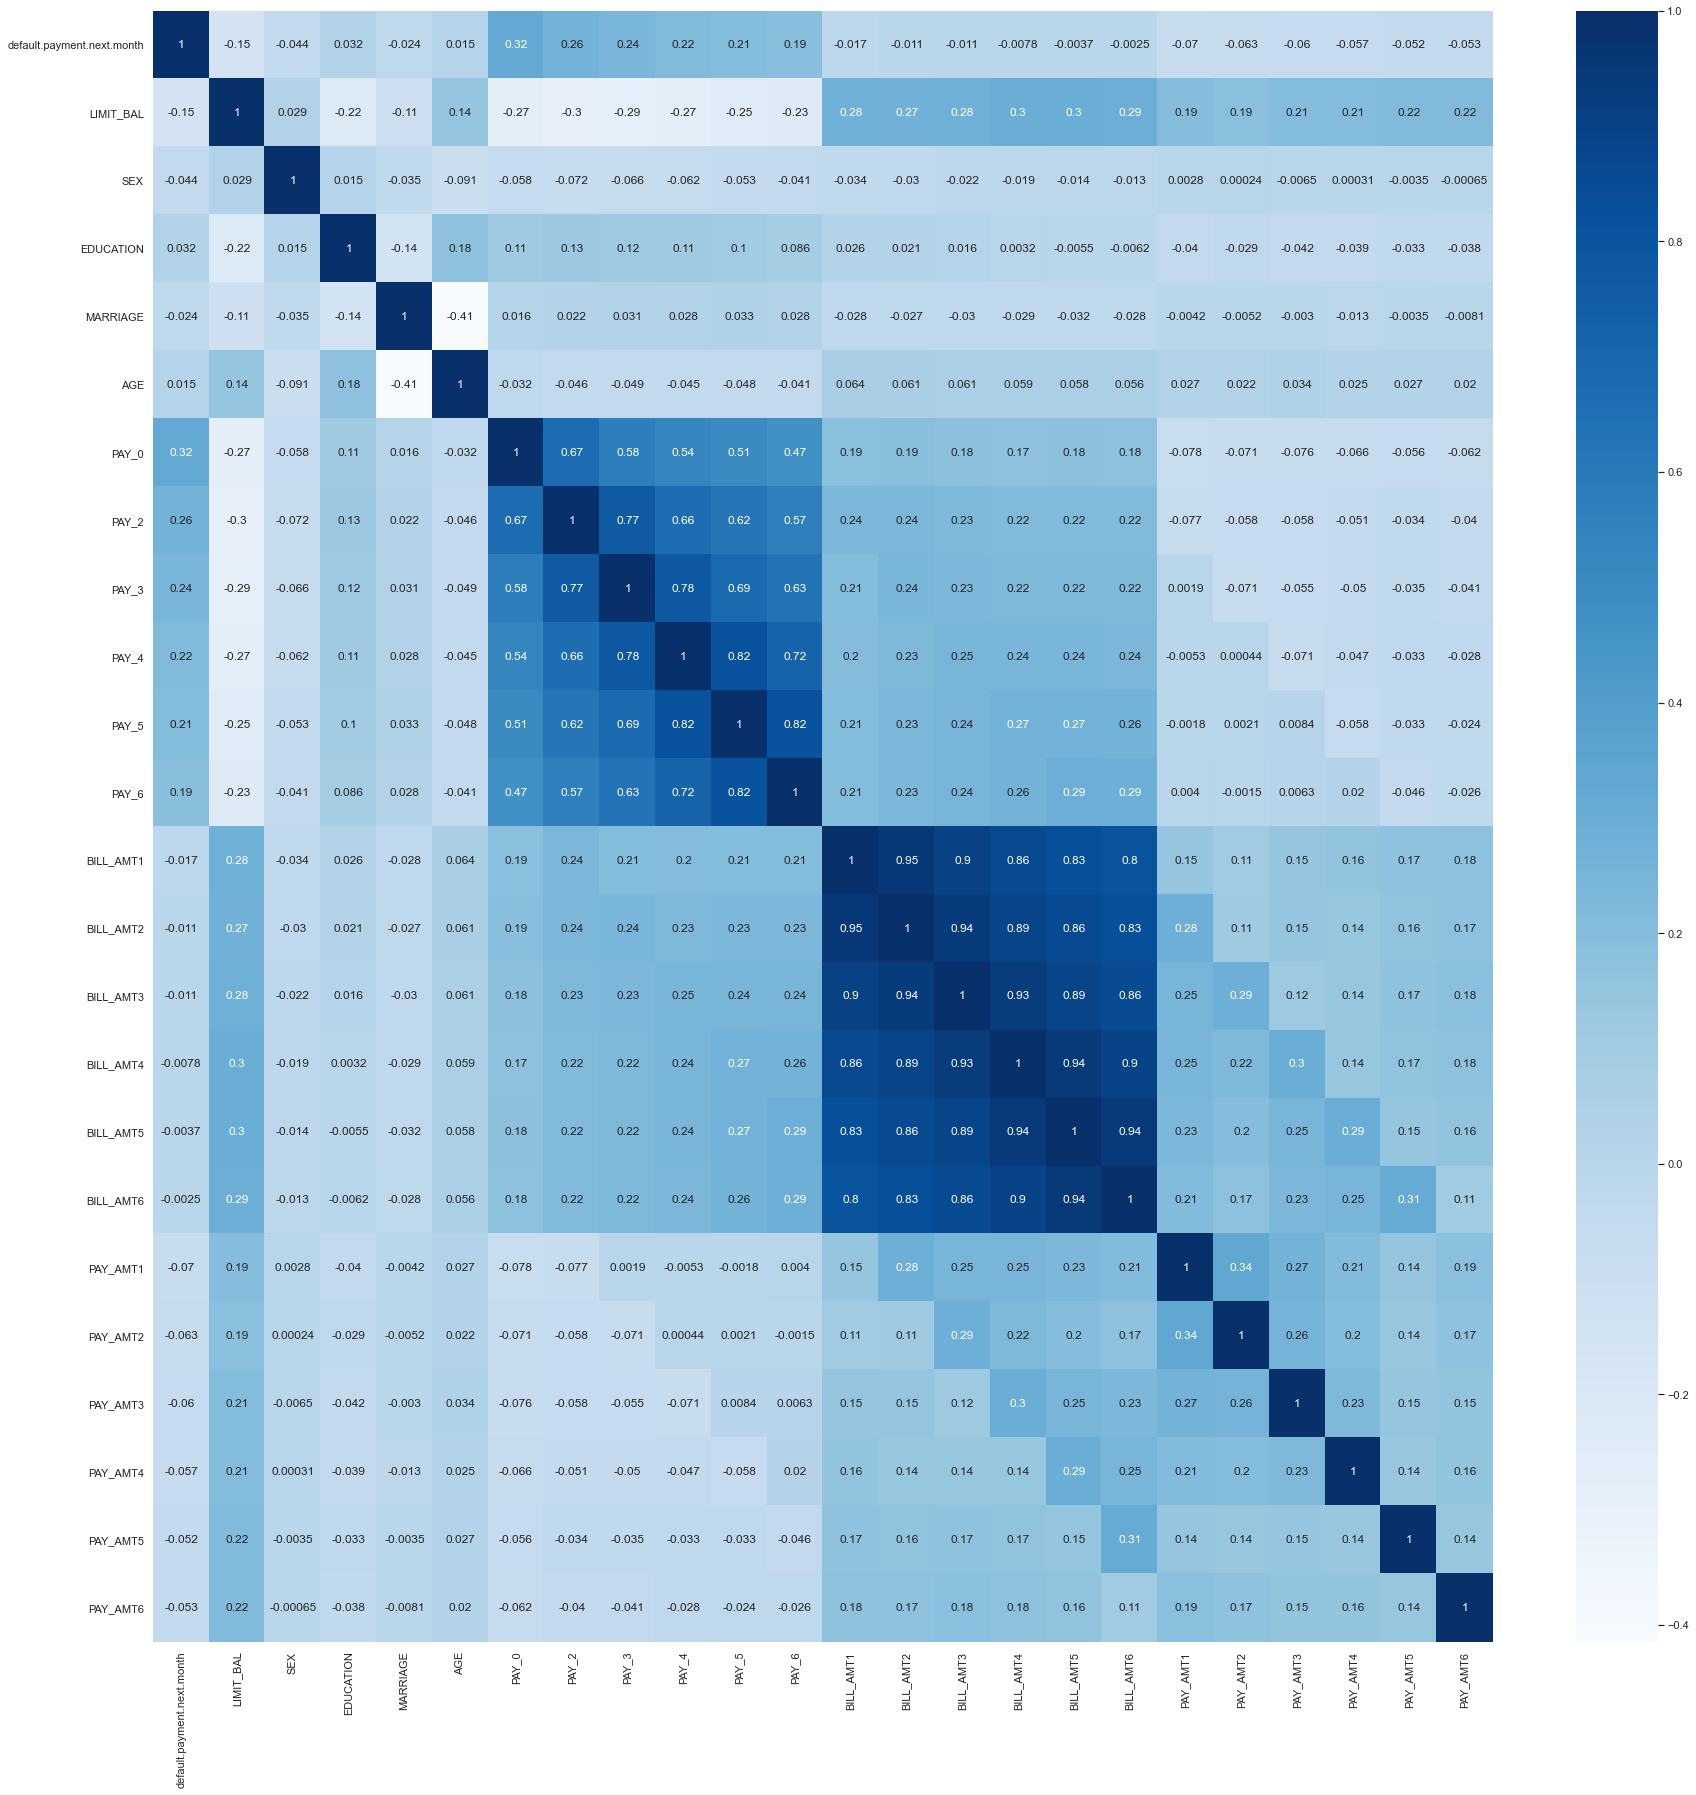

In [23]:
cor = pd.concat((y_train, X_train), axis = 1).iloc[:,:30].corr()
plt.figure(figsize=(30,30))
sns.set(font_scale=1)
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)

All PAY_\d* features and BILL_AMT\d* features are highly correlated

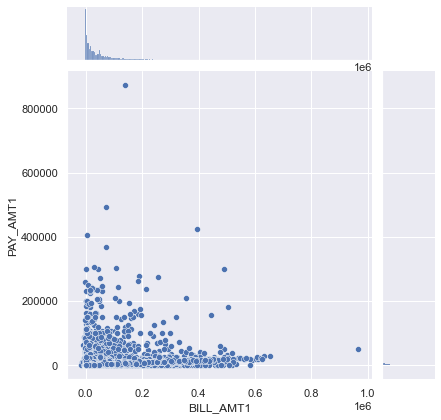

In [26]:
sns.jointplot(x="BILL_AMT1", y="PAY_AMT1", data=X_train)

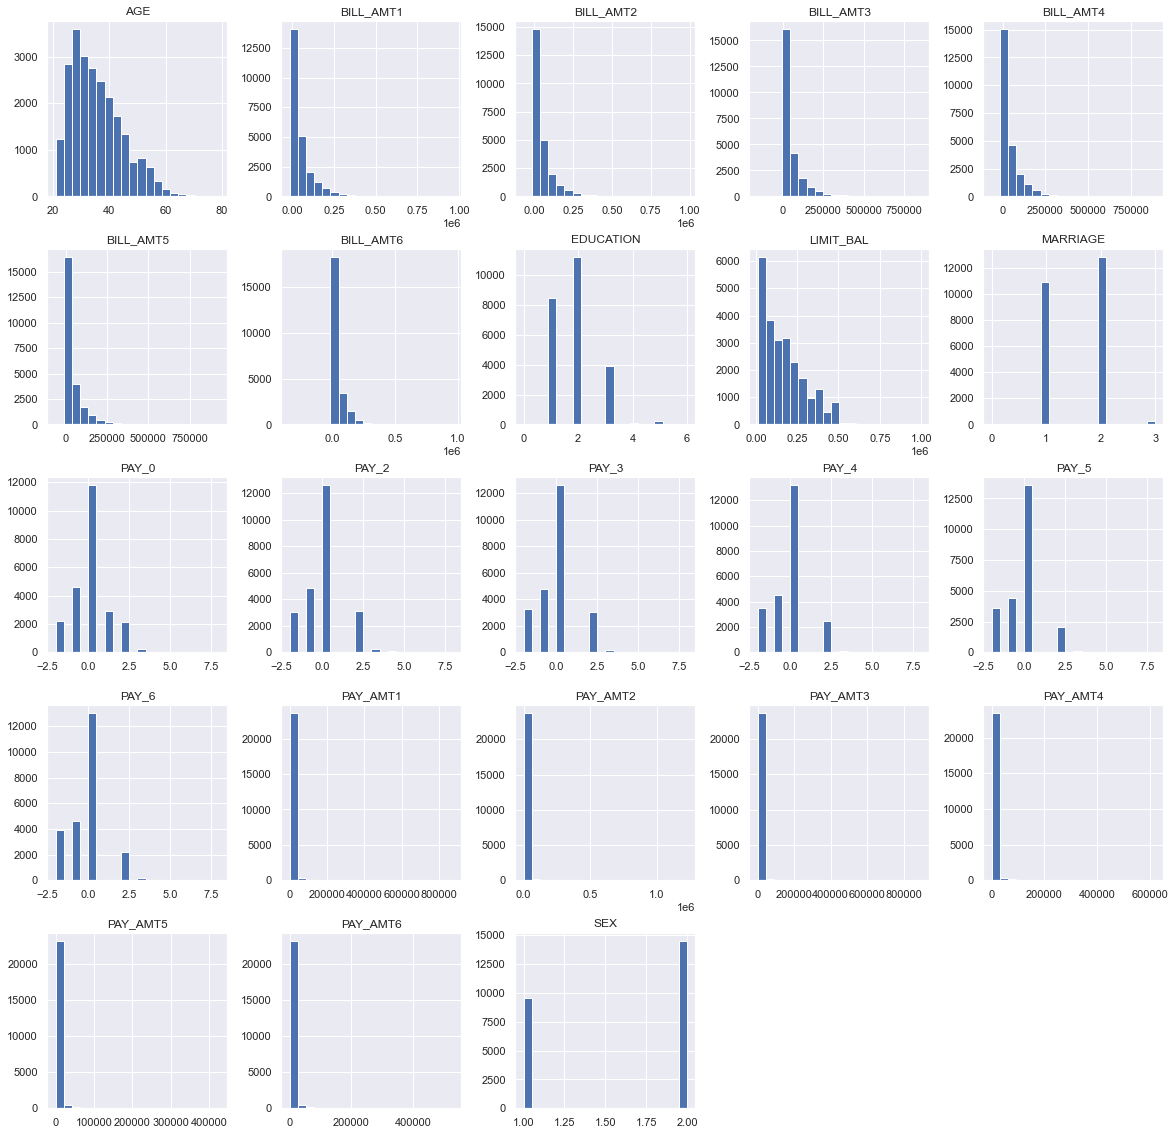

In [27]:
X_train.hist(figsize=(20,20), bins=20);

We see quite a few outliers for features such as EDUCATION, MARRIAGE, and PAY_\d* features.

The feature ranges are very different, so we'll need to standardize.

### 4. Preprocessing and transformations</a>
<hr>

In [34]:
df_carddata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [45]:
numeric_features = ["LIMIT_BAL",
                    "AGE",
                   "PAY_0",
                   "PAY_2",
                   "PAY_3",
                   "PAY_4",
                   "PAY_5",
                   "PAY_6",
                   "BILL_AMT1",
                   "BILL_AMT2",
                   "BILL_AMT3",
                   "BILL_AMT4",
                   "BILL_AMT5",
                   "BILL_AMT6",
                   "PAY_AMT1",
                   "PAY_AMT2",
                   "PAY_AMT3",
                   "PAY_AMT4",
                   "PAY_AMT5",
                   "PAY_AMT6"]

binary_features = ["SEX"]
categorical_features = ["EDUCATION", "MARRIAGE"]

In [49]:
numeric_transformer = make_pipeline(StandardScaler())
categorical_tranformer = make_pipeline(OneHotEncoder(handle_unknown="ignore", sparse = False))
binary_transformer = make_pipeline(OneHotEncoder(drop="if_binary"))

preprocessor = make_column_transformer(
                (numeric_transformer, numeric_features),
                (categorical_tranformer, categorical_features),
                (binary_transformer, binary_features))

preprocessor.fit(X_train, y_train)

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['LIMIT_BAL', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3',
                                  'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1',
                                  'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4',
                                  'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
                                  'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4',
                                  'PAY_AMT5', 'PAY_AMT6']),
                                ('pipeline-2',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['EDUCATION', 'MARRIAGE']),
                                ('pipe

### 5. Baseline Model</a>
<hr>

In [50]:
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)


In [54]:
scoring_metrics = ["f1_macro","average_precision"]

In [59]:
results={}

dummy_model = DummyClassifier(strategy="stratified")
results["dummy"] = mean_std_cross_val_scores(dummy_model, X_train,y_train, return_train_score=True, scoring=scoring_metrics)
pd.DataFrame(results)

,dummy
fit_time,0.003 (+/- 0.000)
score_time,0.005 (+/- 0.003)
test_f1_macro,0.502 (+/- 0.009)
train_f1_macro,0.499 (+/- 0.004)
test_average_precision,0.222 (+/- 0.002)
train_average_precision,0.222 (+/- 0.001)
